In [7]:
import os,sys,shutil
from wand.image import Image as WImage
import numpy
import scipy.stats
import matplotlib.pyplot as plt
import nilearn.plotting
%matplotlib inline
import nibabel
from nipype.interfaces import fsl
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor

from nipype.caching import Memory
# use nipype's caching mechanism to save the results of the processing
mem = Memory(base_dir='.')

# set up rpy2 so we can use R magic
#%load_ext rpy2.ipython

datadir=os.getenv('FMRIBOOKDATA')
if not datadir:
    raise Exception('You need to set the environment variable FMRIBOOKDATA')
else:
    print 'using base dir:',datadir
sys.path.append('../../utils')

from get_data import get_data
data=get_data()

orig_figuredir='https://web.stanford.edu/group/poldracklab/fmri-handbook-2e-data/figures-1e/'

figuredir=os.path.join(datadir,'../../figures')
if not os.path.exists(figuredir):
    os.mkdir(figuredir)

using base dir: /Users/poldrack/data/fmri-handbook-2e-data


__Figure 8.1:__ Use manually generated original

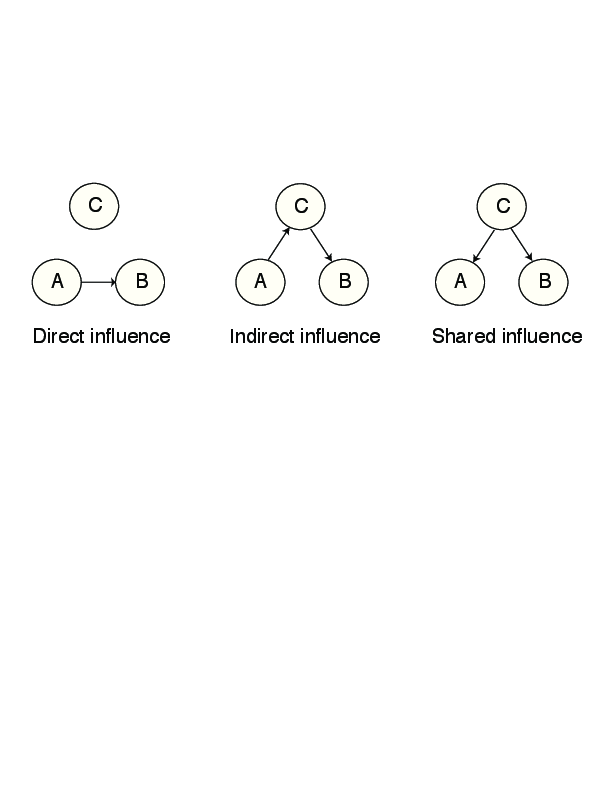

In [3]:
WImage(filename=os.path.join(orig_figuredir,'Figure_8_1.pdf'))

__Figure 8.2:__ Beta-series correlation estimates a response for each trial using a separate regressor, as shown in the design matrix in the middle of the figure. The original timeseries for the two regions plotted in the figure are highly correlated (r = 0.953), due to activation-related transients in the signal. When the beta series is estimated using the general linear model with the design matrix shown in the middle, the resulting estimates show that the trial-by-trial response of these two regions is actually uncorrelated (r = 0.007). Thus, beta-series correlation can identify functional connectivity without being sensitive to activation-induced effects.

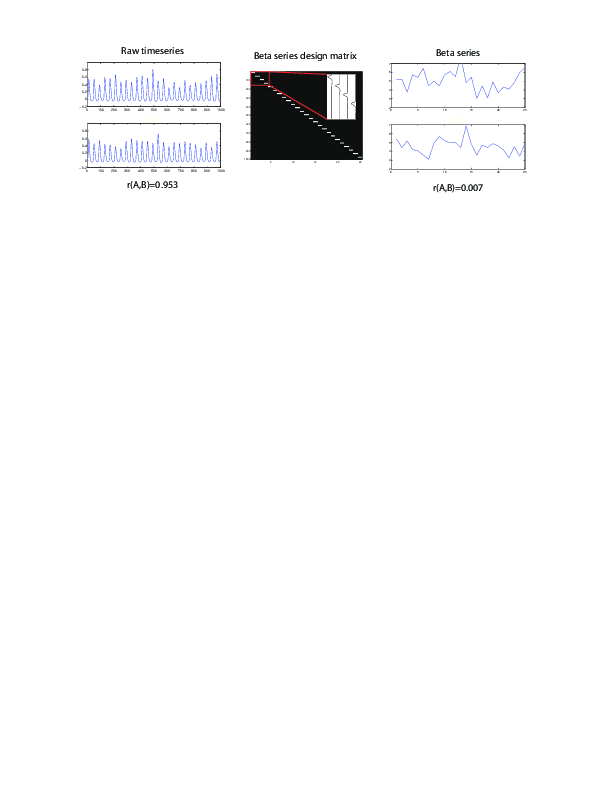

In [85]:
WImage(filename=os.path.join(orig_figuredir,'Figure_8_2.pdf'))

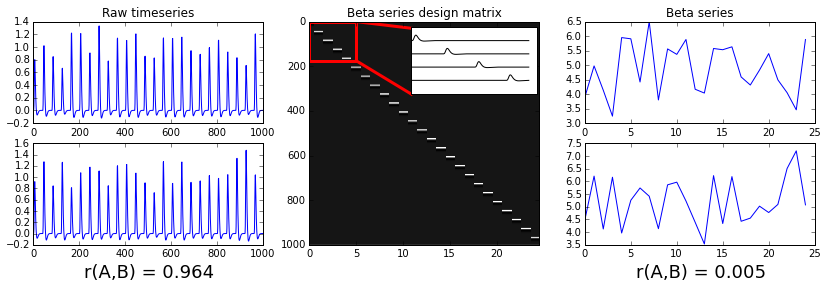

In [94]:

numpy.random.seed(1649)
tslen=1000
onsets=numpy.arange(0,tslen,40)
regressors=numpy.zeros((tslen,len(onsets)))

for i in range(len(onsets)):
    design=([onsets[i]],[1],[1])
    regressor,_=compute_regressor(design,'spm',numpy.arange(0,tslen))
    regressors[:,i]=regressor[:,0]

bsweights=numpy.random.randn(2,25)+5
ts1=regressors.dot(bsweights[0,:])
ts2=regressors.dot(bsweights[1,:])
plt.figure(figsize=(14,4))

ax1 = plt.subplot2grid((2,3), (0,0))
plt.plot(ts1)
plt.title('Raw timeseries')
ax1 = plt.subplot2grid((2,3), (1,0))
plot=plt.plot(ts2)[0]
xlim=plot.axes.get_xlim()
ylim=plot.axes.get_ylim()
plt.xlabel('r(A,B) = %0.3f'%numpy.corrcoef(ts1,ts2)[0,1],fontsize=18)

ax1 = plt.subplot2grid((2,3), (0,2))
plt.plot(bsweights[0,:])
plt.title('Beta series')
ax1 = plt.subplot2grid((2,3), (1,2))
plt.plot(bsweights[1,:])
plt.xlabel('r(A,B) = %0.3f'%numpy.corrcoef(bsweights)[0,1],fontsize=18)

ax1 = plt.subplot2grid((2,3), (0,1),rowspan=2)
plt.imshow(regressors,aspect='auto',interpolation='nearest',cmap='gray')
plt.title('Beta series design matrix')
plt.plot([0,5],[175,175],color='red',linewidth=3)
plt.plot([5,5],[0,175],color='red',linewidth=3)
plt.plot([0,5],[0,0],color='red',linewidth=3)
plt.plot([0,0],[0,175],color='red',linewidth=3)
plt.plot([5,10.9],[175,325],color='red',linewidth=3)
plt.plot([5,10.9],[0,30],color='red',linewidth=3)

plt.axis([0,24.5,1000,0])
a = plt.axes([0.5,0.65,0.125,0.23], axisbg='w')
plt.plot(regressors[:150,0],color='black')
plt.plot(regressors[:150,1]-0.5,color='black')
plt.plot(regressors[:150,2]-1,color='black')
plt.plot(regressors[:150,3]-1.5,color='black')
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(figuredir,'Figure_8_2.svg'),format='svg',dpi=1200)

__Figure 8.3:__ Comparison of PPI and seed voxel correlation results. The left panel shows the results from a PPI analysis on the example dataset; regions showing in color had a significant PPI reflecting greater connectivity with a seed region in the left prefrontal cortex during processing of words versus pseudowords. The right panel shows the results of separate seed voxel correlation analyses using the nuisance model approach. Timepoints from the word blocks are shown in blue and those from the pseudoword blocks are shown in red, with regression lines for each in the same color. The X axis is signal from the left prefrontal seed voxel, and the Y axis is signal from the left inferior occipital region (denoted by yellow crosshairs in the left image). There was a small but significant linear relation between activity in these regions during the word blocks but no such relation in the pseudoword blocks.

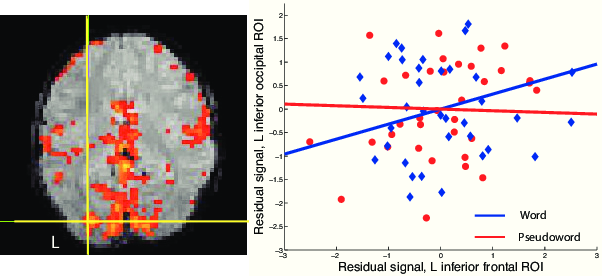

In [95]:
WImage(filename=os.path.join(orig_figuredir,'Figure_8_3.pdf'))

__Figure 8.4:__PCA and ICA find different types of structure in the data. In the top panel, the data are sampled from a Gaussian distribution. The two components detected by each technique are shown as red and green lines. With Gaussian data, PCA finds the direction with the most variance as the first component, and the orthogonal direction as the second component (top left). ICA finds a different set of components with this dataset, which likely reflects fitting to the noise since there is no signal remaining once the data have been whitened (top right). In the lower panel, the data are a mixture of two different signals. PCA cannot find these sources of variance since they are not orthogonal (bottom left), whereas ICA is able to accurately detect the two signals in the data (bottom right).


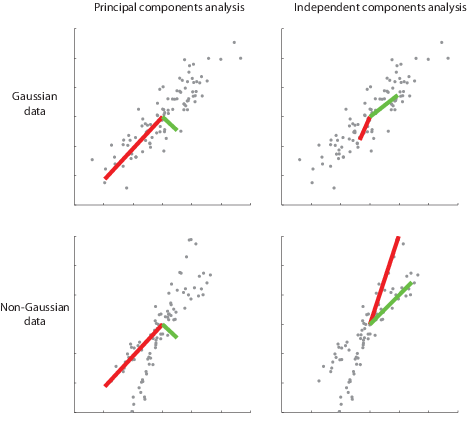

In [96]:
WImage(filename=os.path.join(orig_figuredir,'Figure_8_4.pdf'))

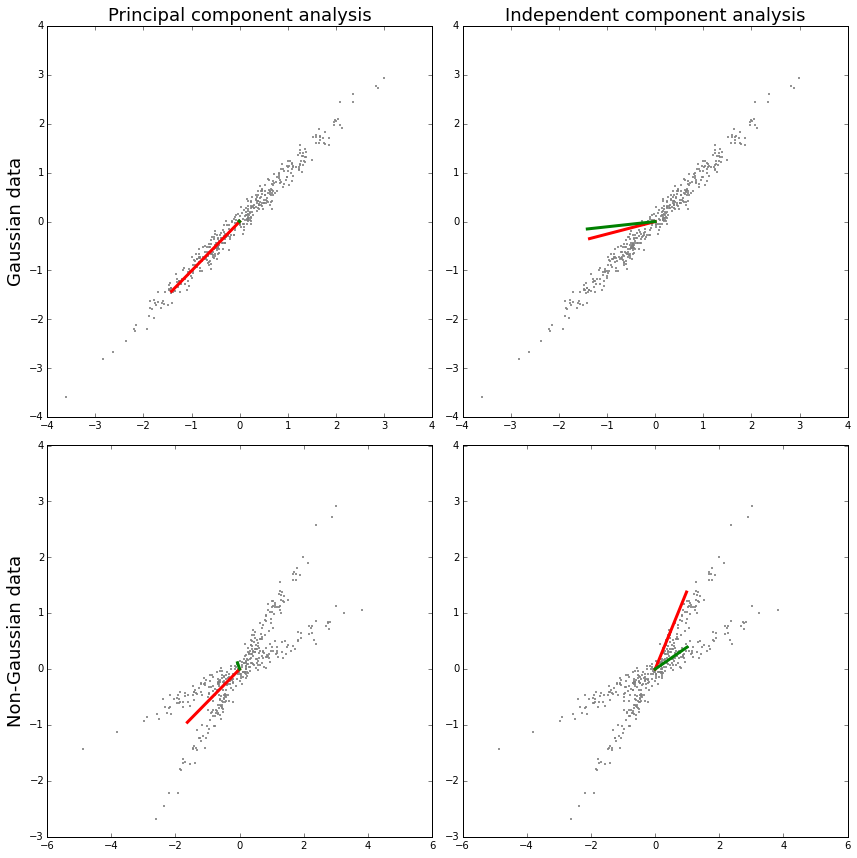

In [206]:
import sklearn.decomposition

#seed=numpy.round(10000*numpy.random.rand())
#print seed
#numpy.random.seed(seed.astype('int'))
numpy.random.seed(2725)
plt.figure(figsize=(12,12))
cov=0.99
data_g=numpy.random.multivariate_normal([0,0],[[1,cov],[cov,1]],400)
data_g=data_g - numpy.mean(data_g,0)
rot=numpy.zeros((2,2))
angle=0.5
rot[0,0]=numpy.cos(angle)
rot[1,1]=numpy.cos(angle)
rot[1,0]=numpy.sin(angle)
rot[0,1]=-1*numpy.sin(angle)
data_ng=numpy.vstack((data_g[:200,:],data_g[200:,:].dot(rot)))
data_ng=data_ng - numpy.mean(data_ng,0)

pca_g=sklearn.decomposition.PCA(n_components=2)
pca_g.fit(data_g)
pca_ng=sklearn.decomposition.PCA(n_components=2)
pca_ng.fit(data_ng)

ica_g=sklearn.decomposition.FastICA(n_components=2,max_iter=2000)
ica_g.fit(data_g)
mix_g=2*ica_g.mixing_/numpy.linalg.norm(ica_g.mixing_)
comp_g=2*ica_g.components_/numpy.linalg.norm(ica_g.components_)

ica_ng=sklearn.decomposition.FastICA(n_components=2,max_iter=2000)
ica_ng.fit(data_ng)
mix_ng=2*ica_ng.mixing_/numpy.linalg.norm(ica_ng.mixing_)
comp_ng=2*ica_ng.components_/numpy.linalg.norm(ica_ng.components_)

plt.subplot(2,2,1)
plt.scatter(data_g[:,0],data_g[:,1],color='gray',s=1)
plt.plot([0,pca_g.components_[0,0]*pca_g.explained_variance_[0]],[0,pca_g.components_[0,1]*pca_g.explained_variance_[0]],color='red',linewidth=3)
plt.plot([0,pca_g.components_[1,0]*pca_g.explained_variance_[1]],[0,pca_g.components_[1,1]*pca_g.explained_variance_[1]],color='green',linewidth=3)
plt.title('Principal component analysis',fontsize=18)
plt.ylabel('Gaussian data',fontsize=18)
plt.subplot(2,2,2)
plt.scatter(data_g[:,0],data_g[:,1],color='gray',s=1)
plt.plot([0,mix_g[0,0]],[0,mix_g[0,1]],color='red',linewidth=3)
plt.plot([0,mix_g[1,0]],[0,mix_g[1,1]],color='green',linewidth=3)
plt.title('Independent component analysis',fontsize=18)

plt.subplot(2,2,3)
plt.scatter(data_ng[:,0],data_ng[:,1],color='gray',s=1)
plt.plot([0,pca_ng.components_[0,0]*pca_ng.explained_variance_[0]],[0,pca_ng.components_[0,1]*pca_ng.explained_variance_[0]],color='red',linewidth=3)
plt.plot([0,pca_ng.components_[1,0]*pca_ng.explained_variance_[1]],[0,pca_ng.components_[1,1]*pca_ng.explained_variance_[1]],color='green',linewidth=3)
plt.ylabel('Non-Gaussian data',fontsize=18)

plt.subplot(2,2,4)
plt.scatter(data_ng[:,0],data_ng[:,1],color='gray',s=1)
plt.plot([0,mix_ng[0,0]],[0,mix_ng[0,1]],color='red',linewidth=3)
plt.plot([0,mix_ng[1,0]],[0,mix_ng[1,1]],color='green',linewidth=3)

plt.tight_layout()
plt.savefig(os.path.join(figuredir,'Figure_8_4.svg'),format='svg',dpi=1200)

__Figure 8.5:__ PCA applied to the example dataset. The left panels show the voxels that load strongly on two particular PCA components (red: positive loading, blue: negative loading), and the right panels show the timecourse of each component. Component #2 has the hallmarks of slow sideways motion, as highlighted by positive loading on one side and negative loading on the other side of the brain along with a slowly drifting timecourse. Component #3 appears to be task-related in its timecourse and shows positive loading in the frontal lobes bilaterally.

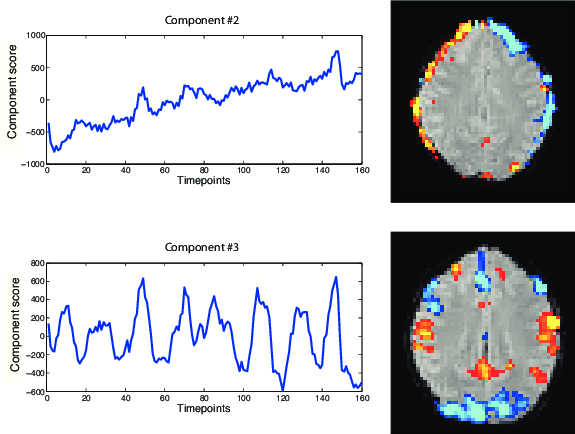

In [97]:
WImage(filename=os.path.join(orig_figuredir,'Figure_8_5.pdf'))

(64, 64, 33, 3)


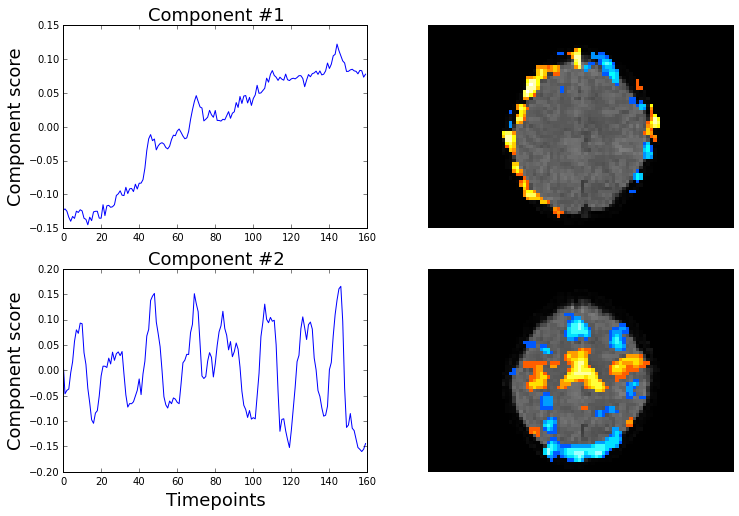

In [316]:
from nilearn.input_data import NiftiMasker


rhymefile=os.path.join(datadir,
    'OLP_01_1/bold/rhyming_bold_mcf_brain_smoothed.nii.gz')
rhymemeanfile=os.path.join(datadir,
    'OLP_01_1/bold/rhyming_bold_mcf_brain_mean.nii.gz')
rhymemask=os.path.join(datadir,
    'OLP_01_1/bold/rhyming_bold_mcf_brain_mask.nii.gz')


try:
    pca_img
except:
    nifti_masker = NiftiMasker(mask_img=rhymemask, standardize=True)
    fmri_masked = nifti_masker.fit_transform(rhymefile)

    pca=sklearn.decomposition.PCA(n_components=3)
    pca_fitted=pca.fit_transform(fmri_masked.T)
    pca_img=nifti_masker.inverse_transform(pca_fitted.T)

print pca_img.shape
cut_coords=[20]
plt.figure(figsize=(12,8))

ax1 = plt.subplot2grid((2,2), (0,0))
plt.plot(pca.components_[0,:])
plt.title('Component #1',fontsize=18)
plt.ylabel('Component score',fontsize=18)

ax1 = plt.subplot2grid((2,2), (0,1))
c1img=pca_img.get_data()[:,:,:,0]
comp1=nibabel.Nifti1Image(c1img,
                          nibabel.load(rhymemask).get_affine(),
                          nibabel.load(rhymemask).get_header())
thresh=scipy.stats.scoreatpercentile(c1img.ravel(),95)
nilearn.plotting.plot_stat_map(comp1,nibabel.load(rhymemeanfile),
                               axes=ax1,threshold=thresh,cut_coords=cut_coords,
                               display_mode='z',colorbar=False,annotate=False)

ax1 = plt.subplot2grid((2,2), (1,0))
plt.plot(pca.components_[1,:])
plt.title('Component #2',fontsize=18)
plt.xlabel('Timepoints',fontsize=18)
plt.ylabel('Component score',fontsize=18)

ax1 = plt.subplot2grid((2,2), (1,1))

c2img=pca_img.get_data()[:,:,:,1]

comp2=nibabel.Nifti1Image(c2img,
                          nibabel.load(rhymemask).get_affine(),
                          nibabel.load(rhymemask).get_header())
thresh=scipy.stats.scoreatpercentile(c2img.ravel(),95)
nilearn.plotting.plot_stat_map(comp2,nibabel.load(rhymemeanfile),
                               axes=ax1,threshold=thresh,cut_coords=cut_coords,
                              display_mode='z',colorbar=False,annotate=False)

plt.savefig(os.path.join(figuredir,'Figure_8_5.svg'),format='svg',dpi=1200)

__Figure 8.6:__ ICA applied to the example dataset. The top panels show data from a component that appears to represent high-frequency oscillations, most likely due to cardiac pulsation. This component loaded most heavily in the most inferior slices covering the brain stem, as shown in the slice image. The bottom panels show a component that has a potentially task-relevant waveform and show heaviest loading in the medial parietal and intraparietal regions. ICA was performed using using the FastICA toolbox for MATLAB.

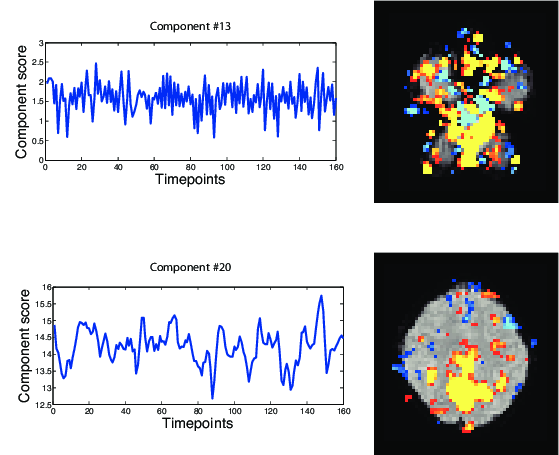

In [253]:
WImage(filename=os.path.join(orig_figuredir,'Figure_8_6.pdf'))

(64, 64, 33, 25)


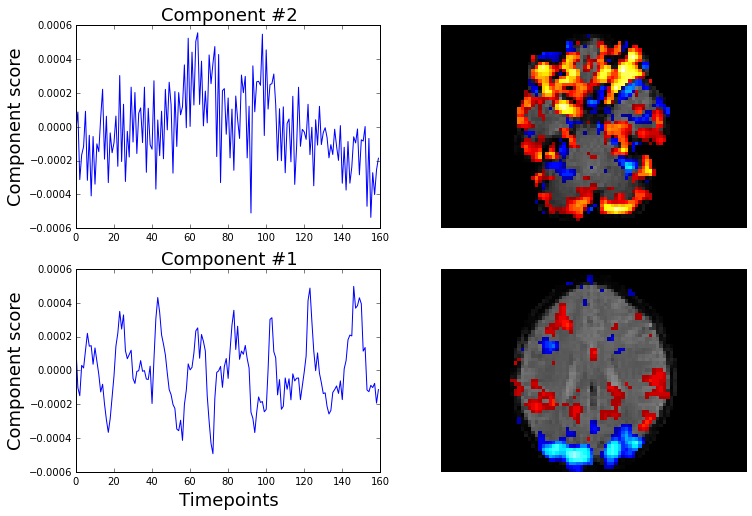

In [315]:
try:
    ica_img
except:

    ica=sklearn.decomposition.FastICA(n_components=25,max_iter=10000,algorithm='parallel')
    ica_fitted=ica.fit_transform(fmri_masked.T)
    ica_img=nifti_masker.inverse_transform(ica_fitted.T)

print ica_img.shape
cut_coords=[-55]
plt.figure(figsize=(12,8))
compnum=1
ax1 = plt.subplot2grid((2,2), (0,0))
plt.plot(ica.components_[compnum,:])
plt.title('Component #%d'%int(compnum+1),fontsize=18)
plt.ylabel('Component score',fontsize=18)

ax1 = plt.subplot2grid((2,2), (0,1))
c1img=ica_img.get_data()[:,:,:,compnum]*1000.
comp1=nibabel.Nifti1Image(c1img,
                          nibabel.load(rhymemask).get_affine(),
                          nibabel.load(rhymemask).get_header())
thresh=scipy.stats.scoreatpercentile(c1img.ravel(),95)
nilearn.plotting.plot_stat_map(comp1,nibabel.load(rhymemeanfile),
                               axes=ax1,cut_coords=cut_coords,threshold=thresh,
                               display_mode='z',colorbar=False,annotate=False)

ax1 = plt.subplot2grid((2,2), (1,0))
compnum=0
cut_coords=[0]

plt.plot(ica.components_[compnum,:])
plt.title('Component #%d'%int(compnum+1),fontsize=18)
plt.xlabel('Timepoints',fontsize=18)
plt.ylabel('Component score',fontsize=18)

ax1 = plt.subplot2grid((2,2), (1,1))

c2img=ica_img.get_data()[:,:,:,compnum]*1000.

comp2=nibabel.Nifti1Image(c2img,
                          nibabel.load(rhymemask).get_affine(),
                          nibabel.load(rhymemask).get_header())
thresh=scipy.stats.scoreatpercentile(c2img.ravel(),95)
nilearn.plotting.plot_stat_map(comp2,nibabel.load(rhymemeanfile),
                               axes=ax1,cut_coords=cut_coords,threshold=thresh,
                              display_mode='z',colorbar=False,annotate=False)

#plt.savefig(os.path.join(figuredir,'Figure_8_6.svg'),format='svg',dpi=1200)

In [312]:
comp1.to_filename(os.path.join(datadir,'comp1.nii.gz'))


__Figure 8.7:__ PLS applied to the example dataset. The top row is the first PLS component; its timecourse reflects a larger response to the first four blocks (the word condition) compared to the second four blocks (the pseudoword condition). The spatial pattern of this component, which closely follows the brain outline in the lower slice shown in the figure, suggests that it likely reflects a task-related motion artifact that subsided over the run. The second row is the second component, which loads roughly equally for both tasks and shows engagement of regions known to be involved in reading. (Thanks to Herve Abdi for the MATLAB code used to create this figure.)

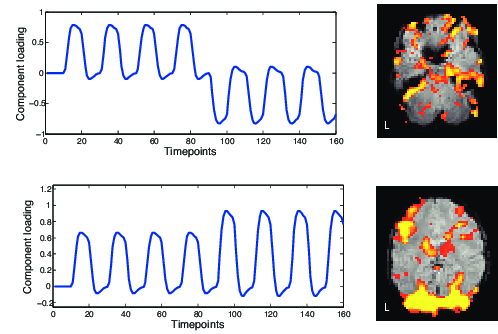

In [100]:
WImage(filename=os.path.join(orig_figuredir,'Figure_8_7.pdf'))

__Figure 8.8:__ Use original art

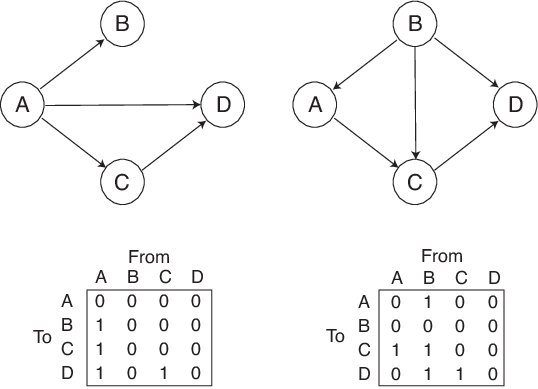

In [99]:
WImage(filename=os.path.join(orig_figuredir,'Figure_8_8.pdf'))

__Figure 8.9:__ Use original art

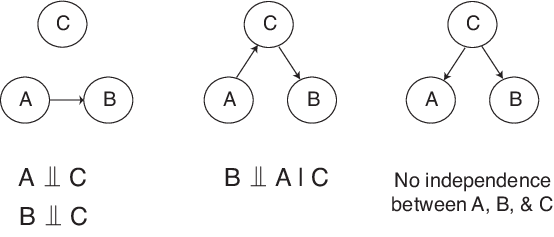

In [101]:
WImage(filename=os.path.join(orig_figuredir,'Figure_8_9.pdf'))

__Figure 8.10:__ A comparison of the best-fitting models estimated using TETRAD IV and modification indices with structural equation modeling, using the example dataset. The data were timecourses from single voxels in five regions (LOCC: left occipital, LMTG: left middle temporal, LIPL: left inferior parietal, LACC: left anterior cingulate, LIFG: left inferior frontal), as well as an exogenous input representing the task convolved with a hemodynamic response. For the TETRAD example, the greedy equivalence search (GES) algorithm was used to search for the best-fitting graph, starting with the knowledge that the input was connected to LOCC. For the SEM example, a greedy search technique was applied as described by using the SEM function in R; starting with a basic model in which the input connected to LOCC, at each stage the edge that increased the model fit most greatly (as measured by modification indices) was added, until the chi-squared test for lack of model fit was no longer significant. The fit of the resulting networks was better for the TETRAD model (BIC = −27) than for the SEM model (BIC = −10).

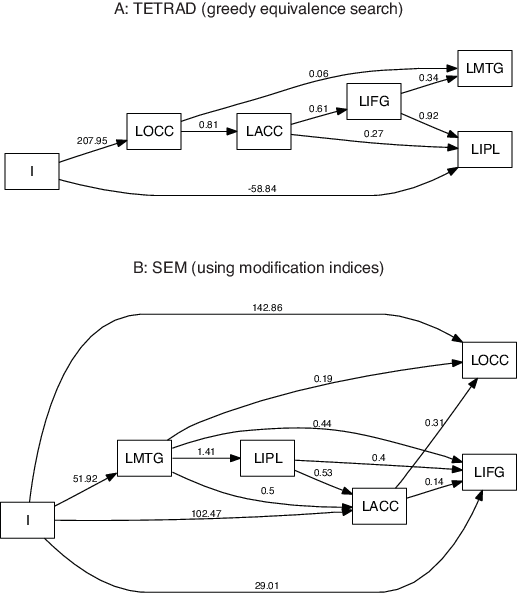

In [102]:
WImage(filename=os.path.join(orig_figuredir,'Figure_8_10.pdf'))

__Figure 8.11:__ A example of a network obtained from analysis of resting state data. The data were obtained from the BIRN data repository and preprocessed as outlined in Section 8.4.3, followed by extraction of signal from the 34 nodes specified by Fair et al. (2009). The nodes are colored according to their involvement in each of the four network outlined by Fair et al. (2009): yellow, frontoparietal; black, cingulo-opercular; red, default mode; blue, cerebellar. The cor- relation matrix was thresholded in order to retain the highest 20% of connections between nodes. The data were visualized using the Kamada-Kawai spring-embedding algorithm, as implemented in the SNA package for R.

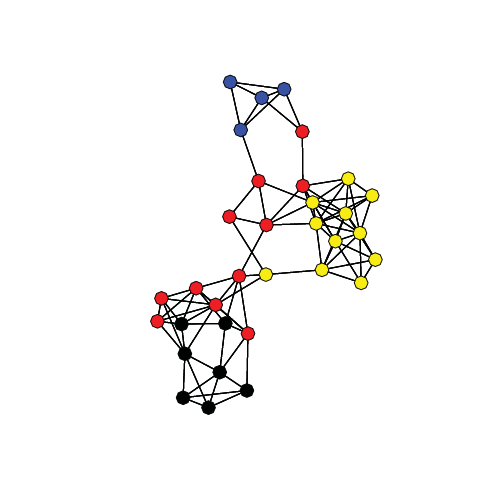

In [103]:
WImage(filename=os.path.join(orig_figuredir,'Figure_8_11.pdf'))